Used Python libraries and SQL syntax to generate visualisations using https://covid.ourworldindata.org/data/owid-covid-data.csv from https://ourworldindata.org/covid-deaths

**Libraries**:
- NumPy
- Pandas
- Pandasql
- Matplotlib
- Seaborn
- Plotly

## **Summary**

In the UK, Between 1st Jan, 2020 and 31st Jan 2023:
- The cumulative % of those who had been infected in reached a peak of 36%
- The % of deaths from COVID-19 reached a peak of 22.9% on 22nd April 2020
- The % of those had had their first vaccination and have been boosted reached a peak of 79.7% and 59.8%, respectively.
- The number of weekly hospital admissions per million reached a peak of 439.2 on 12th Jan 2021

Globally:
- North America and Oceania had the largest and smallest death count of 1,097,034 and 19,078, respectively.
- South America and Oceania had the highest and lowest total deaths per capita from COVID-19, respectively.

In [6]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, plotly.express as px
from pandasql import sqldf
#df = pd.read_csv("~\owid-covid-data.csv")
df = pd.read_csv(r"C:\Users\benjc\Downloads\owid-covid-data.csv")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.date = pd.to_datetime(df.date,yearfirst=True,format='%Y-%m-%d')
df1 = df[df.date.dt.year.between(2020,2022)]
df2 = df[(df.date.dt.year == 2023) & (df.date.dt.month == 1)]
df = pd.concat([df1,df2]).replace(' 00:00:00.000000','',regex=True)

In [7]:
# cases-death ratio in UK --> lineplot
data2=sqldf('''
SELECT date,total_deaths,total_cases, ROUND(total_deaths/total_cases,5) AS death_perc
FROM df
WHERE location LIKE '%United Kingdom%'
''').replace(' 00:00:00.000000','',regex=True)

In [8]:
# cases-population ratio in UK --> lineplot
data3=sqldf('''
SELECT date,total_cases,population, ROUND(total_cases/population*100,5) AS cases_pop
FROM df
WHERE location LIKE '%United Kingdom%'
''').replace(' 00:00:00.000000','',regex=True)

In [9]:
# Highest infection rates per country --> barplot
data4=sqldf('''
SELECT location, MAX(total_cases) max_cases,population, MAX(ROUND(total_cases/population*100,5)) AS max_cases_pop
FROM df
WHERE continent IS NOT NULL 
GROUP BY location,population order by max_cases_pop desc 
''')

In [10]:
# total deaths per continent --> max() b/c total_deaths is cumulative over time t/f get max returns latest total_deaths
data5=sqldf('''
SELECT continent, MAX(Total_deaths) AS TotalDeathCount
FROM df
WHERE continent IS NOT NULL 
GROUP BY continent
ORDER BY TotalDeathCount DESC
''')
# 'location' columns contains both countries & continents therefore max() aggregates both countries & continents
# e.g. Asia can be found in both 'location' and 'continent' cols --> therefore use 'where continent is not null' to only
# include country-level data, not continent-level data in aggregatate function

In [11]:
# num and % of people vaxxed in UK FINAL
data6=sqldf('''
WITH a AS 
    (
    SELECT continent, location, date, population, people_vaccinated,total_boosters
    FROM df
    WHERE continent IS NOT NULL AND location LIKE  '%United Kingdom%'
    )

SELECT *, ROUND((People_Vaccinated/Population)*100,3) AS PercentPeopleVaccinated,
ROUND((total_boosters/Population)*100,3) AS PercentPeopleBoosted
FROM a
WHERE people_vaccinated > 0
''').replace(np.nan,0).replace(' 00:00:00.000000','',regex=True)

In [12]:
# Weekly hospital admissions
data7=sqldf('''
SELECT location, date, population,weekly_hosp_admissions_per_million
FROM df
WHERE continent IS NOT NULL AND location LIKE '%United Kingdom%'
''').replace(np.nan,0).replace(' 00:00:00.000000','',regex=True)

In [68]:
# data3[data3.cases_pop == data3.cases_pop.max()]
# data2[data2.death_perc == data2[data2.death_perc < 1].death_perc.max()]
# data6[data6.PercentPeopleBoosted == data6[data6.PercentPeopleBoosted > 0].PercentPeopleBoosted.max()],data6[data6.PercentPeopleBoosted > 0].iloc[-1]
# data7[data7.weekly_hosp_admissions_per_million == data7.weekly_hosp_admissions_per_million.max()]

,location,date,population,weekly_hosp_admissions_per_million
375,United Kingdom,2021-01-12,67508936.0,439.186


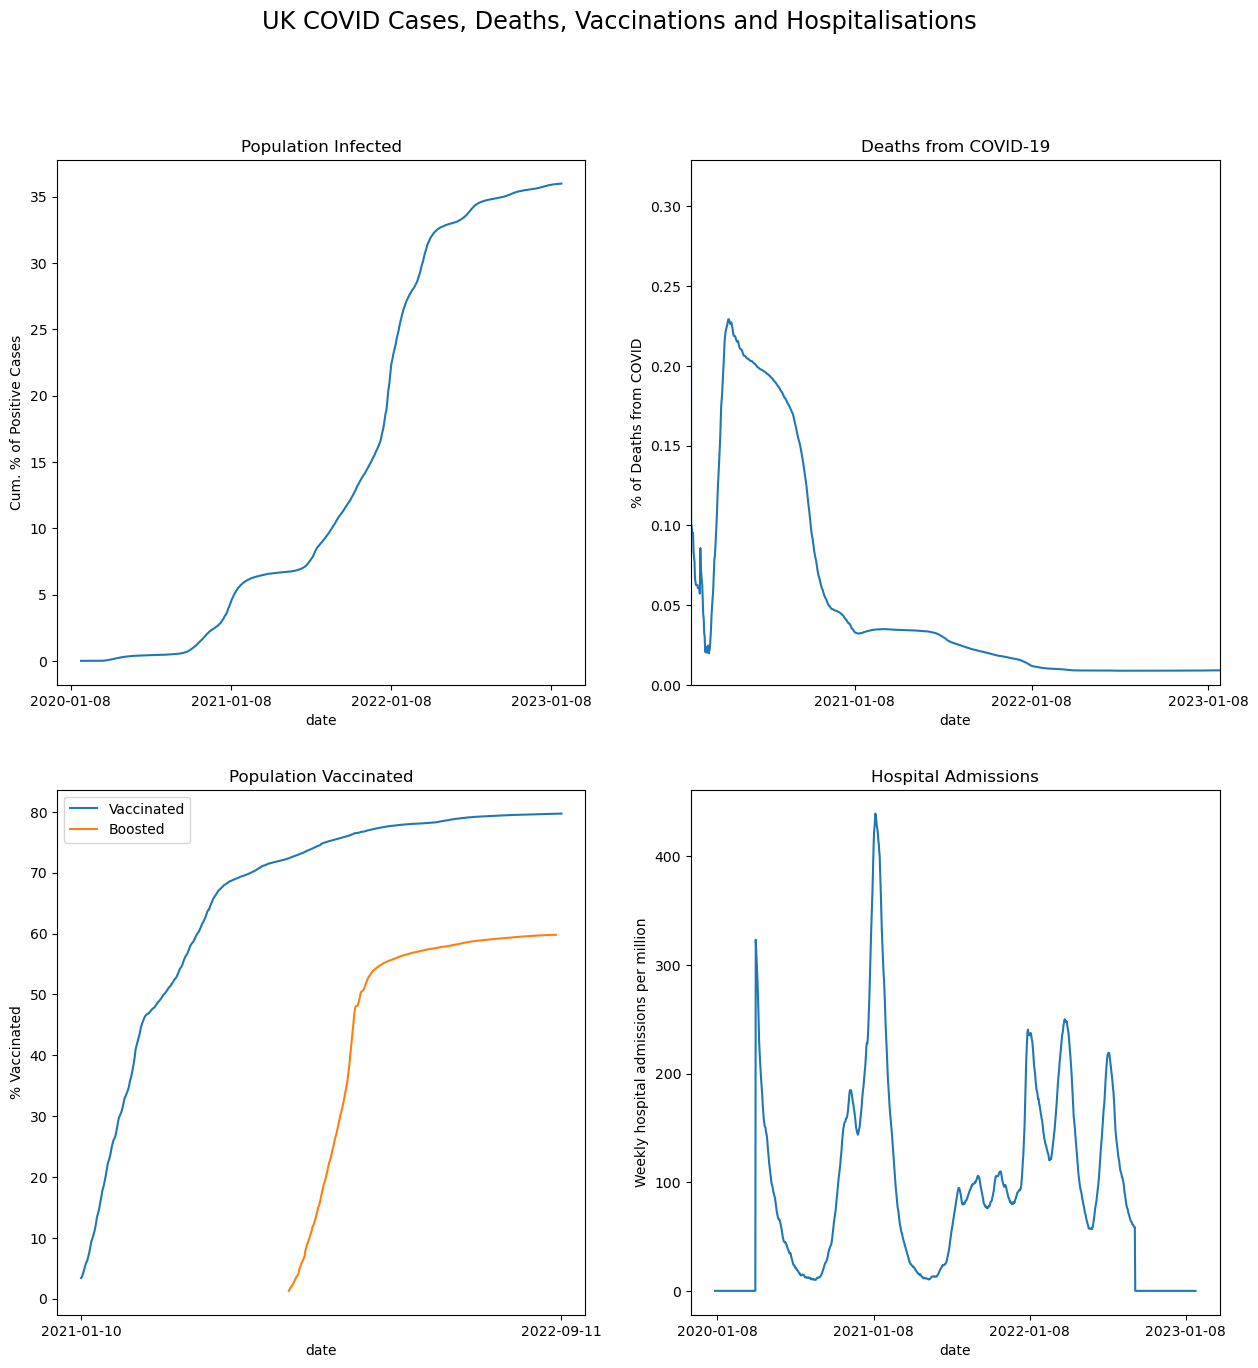

In [49]:
fig,axs = plt.subplots(2,2,figsize=(15,15))
sns.lineplot(data=data3,x='date',y='cases_pop',ax=axs[0,0]) # cases as proportion of population
sns.lineplot(data=data2,x='date',y='death_perc',ax=axs[0,1]) # Death % of total cases 

sns.lineplot(data=data6,x='date',y='PercentPeopleVaccinated',ax=axs[1,0],label='Vaccinated')
sns.lineplot(data=data6[data6.PercentPeopleBoosted > 0],x='date',y='PercentPeopleBoosted',ax=axs[1,0],label='Boosted')
sns.lineplot(data=data7,x='date',y='weekly_hosp_admissions_per_million',ax=axs[1,1])

fig.suptitle('UK COVID Cases, Deaths, Vaccinations and Hospitalisations',fontsize='xx-large')
axs[1,0].ticklabel_format(style='plain',axis='y')
axs[0,0].set_xticks(['2020-01-08','2021-01-08','2022-01-08','2023-01-08'])
axs[0,1].set_xticks(['2020-01-08','2021-01-08','2022-01-08','2023-01-08'])
axs[1,0].set_xticks([data6.date[0],data6.date[len(data6)-1]])
axs[1,1].set_xticks(['2020-01-08','2021-01-08','2022-01-08','2023-01-08'])

axs[0,0].set_title('Population Infected')
axs[0,1].set_title('Deaths from COVID-19')
axs[1,0].set_title('Population Vaccinated')
axs[1,1].set_title('Hospital Admissions')
axs[0,0].set_ylabel('Cum. % of Positive Cases')
axs[0,1].set_ylabel('% of Deaths from COVID')
axs[1,0].set_ylabel('% Vaccinated')
axs[1,1].set_ylabel('Weekly hospital admissions per million')

axs[0,1].set_xlim(data2[data2.death_perc<1].date.reset_index().date[0],data2.iloc[-1].date)
axs[0,1].set_ylim(0,data2[data2.death_perc<1].death_perc.max() + .1);

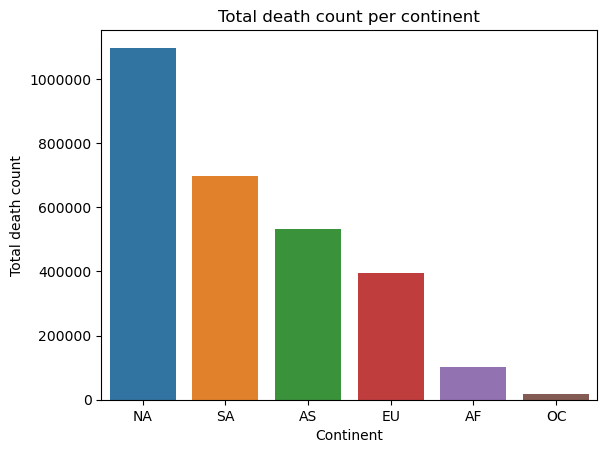

In [21]:
# Total death count per continent
sns.barplot(data=data5\
.replace({'North America':'NA','South America':'SA','Asia':'AS','Africa':'AF','Oceania':'OC','Europe':'EU'})\
.rename(columns={'TotalDeathCount':'Total death count','continent':'Continent'}),\
x='Continent',y='Total death count')
plt.title('Total death count per continent')
plt.ticklabel_format(style='plain',axis='y')

In [17]:
# total deaths per continent --> top 3 countries per continent 
data5v2=sqldf('''
WITH a AS (select *, rank() over (partition by continent order by max_deaths desc) as row
FROM (
    SELECT continent,location, MAX(Total_deaths) AS max_deaths
    FROM df
    WHERE continent IS NOT NULL
    GROUP BY continent,location
    ORDER BY continent,location
    ))
SELECT continent,location,max_deaths, max_deaths / (SELECT MAX(max_deaths) FROM a) AS max_deaths_norm
FROM a 
WHERE row BETWEEN 1 AND 3
''')

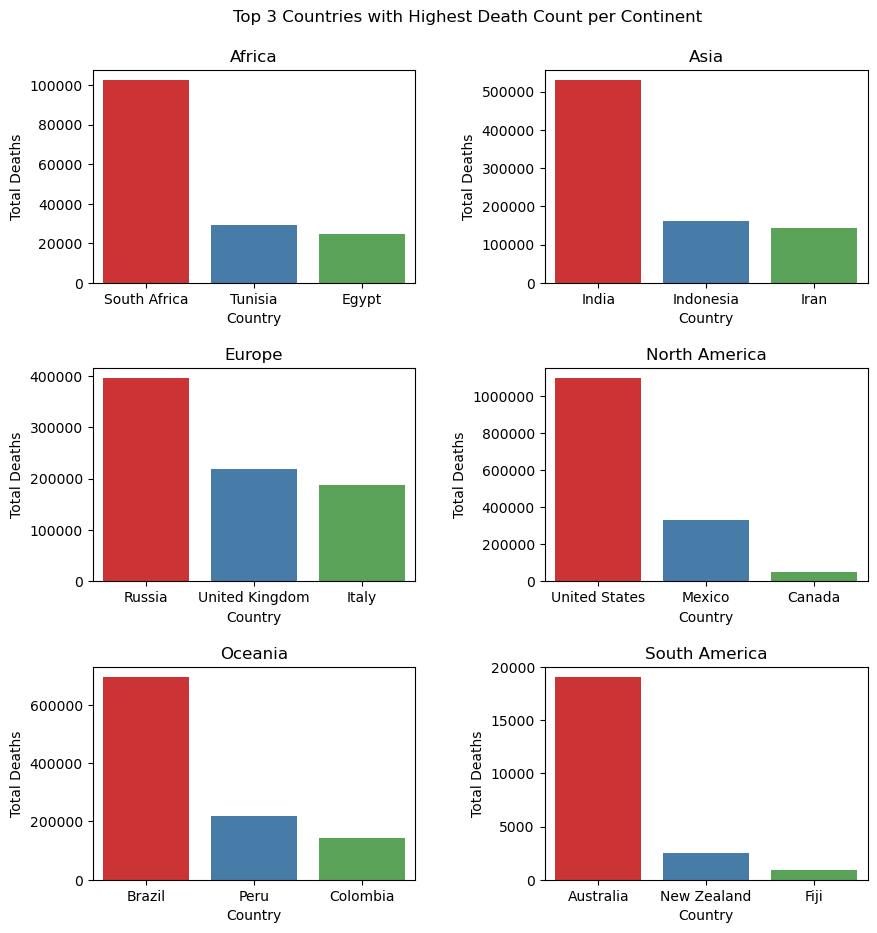

In [18]:
# Top 3 Countries w highest death count per continent
fig,axs = plt.subplots(3,2,figsize=(10,10))
sns.barplot(data=data5v2[data5v2.continent== 'Africa'], x='location', y='max_deaths', palette='Set1',ax=axs[0,0])
sns.barplot(data=data5v2[data5v2.continent== 'Asia'], x='location', y='max_deaths', palette='Set1',ax=axs[0,1])
sns.barplot(data=data5v2[data5v2.continent== 'Europe'], x='location', y='max_deaths', palette='Set1',ax=axs[1,0])
sns.barplot(data=data5v2[data5v2.continent== 'North America'], x='location', y='max_deaths', palette='Set1',ax=axs[1,1])
sns.barplot(data=data5v2[data5v2.continent== 'South America'], x='location', y='max_deaths', palette='Set1',ax=axs[2,0])
sns.barplot(data=data5v2[data5v2.continent == 'Oceania'], x='location', y='max_deaths', palette='Set1',ax=axs[2,1])
axs[1,1].ticklabel_format(style='plain',axis='y')
fig.suptitle('Top 3 Countries with Highest Death Count per Continent')
plt.subplots_adjust(wspace = 0.4,top=.92,hspace=.4)

axes = [ax for ax_lst in axs for ax in ax_lst]
for ax,continent in zip(axes,data5v2.continent.unique()):
    ax.set_title(continent)
    ax.set_ylabel('Total Deaths')
    ax.set_xlabel('Country')

In [ ]:
# total deaths per continent --> top 3 countries per continent V3
data5v2=sqldf('''
WITH max_deaths AS 
    (
    SELECT *, RANK() OVER (PARTITION BY continent ORDER BY max_deaths DESC) AS row
    FROM 
        (
        SELECT continent,location, MAX(Total_deaths) AS max_deaths, population
        FROM df
        WHERE continent IS NOT NULL
        GROUP BY continent,location
        )
    )
SELECT continent,location,max_deaths, ROUND(max_deaths*100  / population,2) AS pop_death
FROM max_deaths
WHERE row BETWEEN 1 AND 3
''')#.head(10)

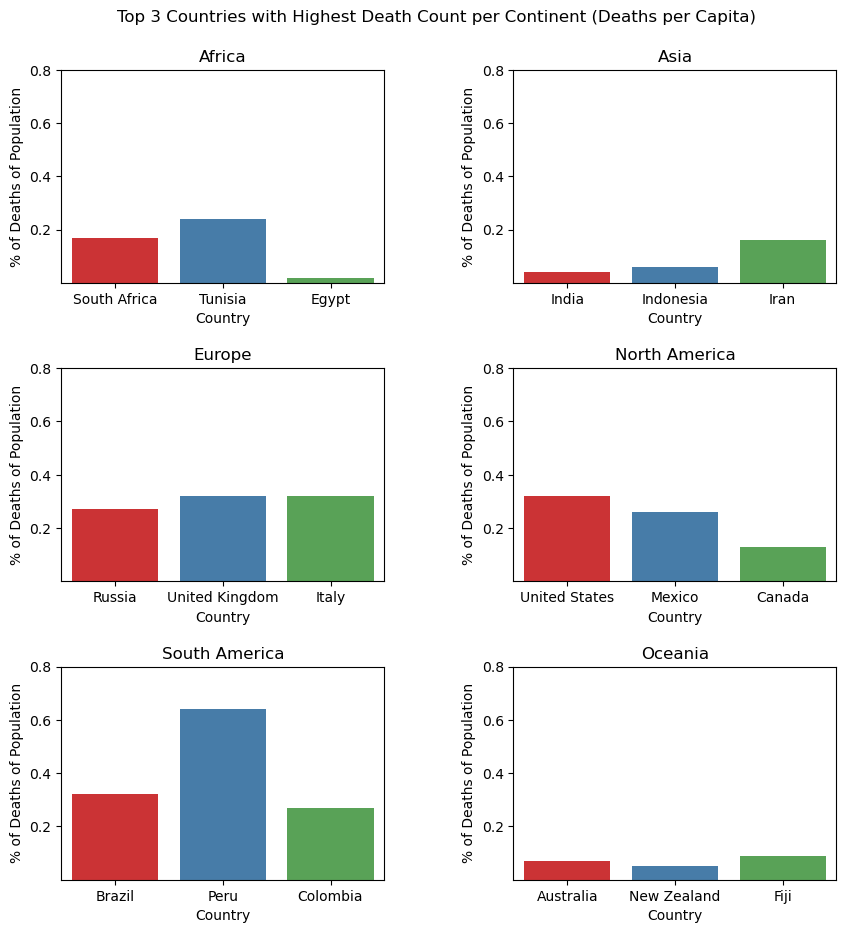

In [98]:
# Top 3 Countries w highest death count per continent (% of country's population)
fig, axs = plt.subplots(3,2,figsize=(10,10))
sns.barplot(data=data5v2[data5v2.continent == 'Africa'], x='location', y='pop_death', palette='Set1',ax=axs[0,0])
sns.barplot(data=data5v2[data5v2.continent == 'Asia'], x='location', y='pop_death', palette='Set1',ax=axs[0,1])
sns.barplot(data=data5v2[data5v2.continent == 'Europe'], x='location', y='pop_death', palette='Set1',ax=axs[1,0])
sns.barplot(data=data5v2[data5v2.continent == 'North America'], x='location', y='pop_death', palette='Set1',ax=axs[1,1])
sns.barplot(data=data5v2[data5v2.continent == 'South America'], x='location', y='pop_death', palette='Set1',ax=axs[2,0])
sns.barplot(data=data5v2[data5v2.continent == 'Oceania'], x='location', y='pop_death', palette='Set1',ax=axs[2,1])
plt.ticklabel_format(style='plain',axis='y')
fig.suptitle('Top 3 Countries with Highest Death Count per Continent (Deaths per Capita)')
plt.subplots_adjust(wspace = 0.4,top=.92,hspace=.4)

axes = [ax for ax_lst in axs for ax in ax_lst]
for ax,continent in zip(axes,data5v2.continent.unique()):
    ax.set_title(continent)
    ax.set_ylabel('% of Deaths of Population')
    ax.set_xlabel('Country')
    ax.set_yticks([.2,.4,.6,.8])
axs[2,0].set_title('South America')
axs[2,1].set_title('Oceania');

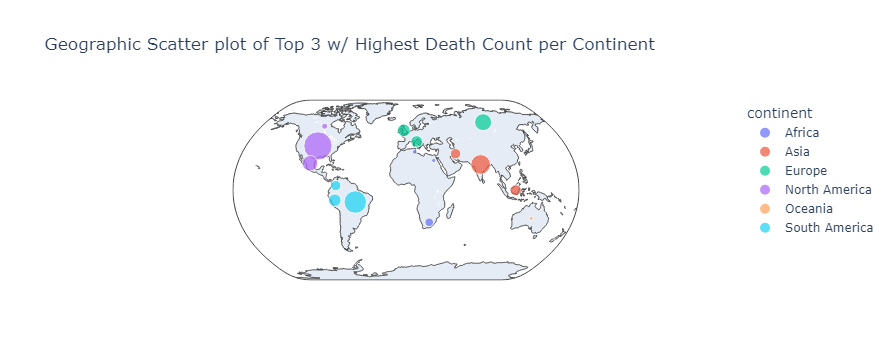

In [101]:
plotly_fig = px.scatter_geo(data_frame=sqldf('''
WITH max_deaths AS 
    (SELECT *, RANK() OVER (PARTITION BY continent ORDER BY total_deaths DESC) AS row
    FROM 
        (
        SELECT iso_code,continent,location, MAX(Total_deaths) AS total_deaths
        FROM df
        WHERE continent IS NOT NULL
        GROUP BY iso_code,continent
        )
    )
SELECT iso_code, continent, location, total_deaths
FROM max_deaths
WHERE row BETWEEN 1 AND 3
'''), locations='iso_code', color='continent', hover_name='location',
projection='natural earth',size='total_deaths',title='Geographic Scatter plot of Top 3 w/ Highest Death Count per Continent')
plotly_fig.show()